In [130]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time

# Update path
import sys
sys.path.append("../src/manipulatorSourceFiles")
from models import DeepONetProjected, FNOProjected, FNOGRUNet, DeepONetGRUNet, ml_predictor_fno, ml_predictor_deeponet
from config import SimulationConfig, ModelConfig
from dataset import gen_dataset
from robot import Manipulator
from trainer import model_trainer, evaluate_train_performance, evaluate_model
from utils import plot_trajectory, count_parameters

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load our simulation configurations
Config can be loaded through "../config/manipulatorConfig/config.toml" or specified for this file in particular using the settings below. 

In [4]:
#sim_config_path = "../config/manipulatorConfig/config.toml"
#sim_config = SimulationConfig(sim_config_path)

dynamics_config = {
    "dof": 5, # Controls number of manipulator links. Min=1, Max=5
    "T": 10, # Simulation final time
    "scaling": 0.1, # Controls the scale of the sin wave for trajectory following
    "period": 1, # Controls the period of the sin wave for trajectory following
    "dt": 0.1, # Simulation step size
    "D": 0.5 # Delay length
}

dataset_config = {
    "num_data": 250000, # Amount of data instances to generate
    "deviation": 0.5, # Controls how much Gaussian pertubation to add to predictor for generating dataset trajs
    "dataset_filename": "Manipulator", # Filename of dataset
    "test_size": 0.1, # Train test split size. Between 0 and 1
    "batch_size": 512, # Batch size used for loading dataset into torch dataloaders
    "random_state": 1, # Randomstate to start generating dataset from
    "device_name": "cuda" # CPU or GPU device for loading data on to 
}

# Uncomment to load file. 
#sim_config_path = "../config/manipulatorConfig/config.toml"
#sim_config = SimulationConfig(sim_config_path)

# Uncomment to load from above specifications
sim_config = SimulationConfig({"dynamics": dynamics_config, "dataset": dataset_config})

### Build dataset 
(Optional) Dataset is available on huggingface for download instead of building from scratch. This will take a while to run if you chose to build from scratch 

In [7]:
# Choose gain matrices for the feedback linearization in the sim
alpha_matrix = np.identity(sim_config.dof)
beta_matrix = np.identity(sim_config.dof)

# Set max and min joint limits
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])
joint_lim_min = joint_lim_min[0:sim_config.dof]
joint_lim_max = joint_lim_max[0:sim_config.dof]

# Build the simulation object
robot = Manipulator(sim_config.dof, sim_config.alpha_mat, sim_config.beta_mat)

# Generate dataset. Uncomment to run
#gen_dataset(sim_config.num_data, robot, sim_config.dt, sim_config.T, dof, sim_config.D, \
#            sim_config.scaling, sim_config.period, joint_lim_min, joint_lim_max, \
#            sim_config.deviation, sim_config.dataset_filename)

### Load our Model configurations
Config can be loaded through "../config/manipulatorConfig/{model_name}.toml" or specified for this file in particular using the settings below. 

In [167]:
# Configure FNO
train_config_fno = {
    "model_filename": "fno", # File to save/load trained model
    "model_type": "FNO",  # Specifies what model we are loading
    "epochs": 400,  # Specifies the number of epochs to train model
    "gamma": 0.99, # Specifies the learning rate scheduling parameter
    "learning_rate": 5e-3, # Specifies the learning rate
    "weight_decay": 0, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno = {
    "hidden_size": 64, # Specifies number of neurons per layer
    "modes": 4, # Specifies number of fourier nodes to use
    "num_layers": 4, # Specifies number of layers
}

# Uncomment to load file. 
#fno_config_path = "../config/manipulatorConfig/fno.toml"
#fno_config = ModelConfig(fno_config_path)

# Uncoment to load from above specifications
fno_config = ModelConfig({"train": train_config_fno, "FNO": architecture_config_fno})

# Build archtiecture. Note that input and output channels depend on DOF chosen and so we update here.
fno_config.update_config(input_channel=3*sim_config.dof, output_channel=2*sim_config.dof)
fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel, sim_config.dof, sim_config.nD)

In [151]:
# Configure DeepONet
train_config_deeponet = {
    "model_filename": "deeponet", # File to save/load trained model
    "model_type": "DeepONet",  # Specifies what model we are loading
    "epochs": 500,  # Specifies the number of epochs to train model
    "gamma": 0.999, # Specifies the learning rate scheduling parameter
    "learning_rate": 8e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet = {
    "hidden_size": 512, # Specifies number of neurons per layer
    "num_layers": 5, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
}

# Uncomment to load file. 
#deeponet_config_path = "../config/manipulatorConfig/deeponet.toml"
#deeponet_config = ModelConfig(deeponet_config_path)

# Uncoment to load from above specifications
deeponet_config = ModelConfig({"train": train_config_deeponet, "DeepONet": architecture_config_deeponet})

# Build archtiecture. Note that input and output channels depend on DOF chosen and so we update here.
deeponet_grid = np.arange(0, sim_config.D, sim_config.dt/(3*sim_config.dof)).astype(np.float32)
deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=sim_config.nD*2*sim_config.dof)
deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                            deeponet_config.input_channel, deeponet_config.output_channel, \
                            deeponet_grid, sim_config.dof, sim_config.nD)

In [40]:
# Configure FNO GRU
train_config_fno_gru = {
    "model_filename": "fnogru", # File to save/load trained model
    "model_type": "FNO+GRU",  # Specifies what model we are loading
    "epochs": 400,  # Specifies the number of epochs to train model
    "gamma": 0.99, # Specifies the learning rate scheduling parameter
    "learning_rate": 5e-3, # Specifies the learning rate
    "weight_decay": 0, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno_gru = {
    "fno_hidden_size": 64, # Specifies number of neurons per layer FNO
    "modes": 12, # Specifies number of fourier nodes to use
    "fno_num_layers": 4, # Specifies number of layers FNO
    "gru_hidden_size": 64, # Specifies number of neurons per layer GRU
    "gru_num_layers": 4
}

# Uncomment to load file. 
#fno_gru_config_path = "../config/manipulatorConfig/fnogru.toml"
#fno_gru_config = ModelConfig(fno_gru_config_path)

# Uncoment to load from above specifications
fno_gru_config = ModelConfig({"train": train_config_fno_gru, "FNOGRU": architecture_config_fno_gru})

# Build architecture. Note that input and output channels depend on DOF chosen and so we update here.
fno_gru_config.update_config(input_channel=3*sim_config.dof, output_channel=2*sim_config.dof)
fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
          fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
          fno_gru_config.output_channel, sim_config.dof, sim_config.nD)

In [115]:
# Configure DeepONet GRU
train_config_deeponet_gru = {
    "model_filename": "deeponetgru", # File to save/load trained model
    "model_type": "DeepONet+GRU",  # Specifies what model we are loading
    "epochs": 500,  # Specifies the number of epochs to train model
    "gamma": 0.999, # Specifies the learning rate scheduling parameter
    "learning_rate": 8e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet_gru = {
    "deeponet_hidden_size": 1024, # Specifies number of neurons per layer
    "deeponet_num_layers": 5, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
    "gru_num_layers": 5, 
    "gru_hidden_size": 64,
}

# Uncomment to load file. 
deeponet_gru_config_path = "../config/manipulatorConfig/deeponetgru.toml"
deeponet_gru_config = ModelConfig(deeponet_gru_config_path)

# Uncoment to load from above specifications
deeponet_gru_config = ModelConfig({"train": train_config_deeponet_gru, "DeepONetGRU": architecture_config_deeponet_gru})

# Build archtiecture. Note that input and output channels depend on DOF chosen and so we update here.
deeponet_gru_grid = np.arange(0, sim_config.D, sim_config.dt/(3*sim_config.dof)).astype(np.float32)
deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=sim_config.nD*2*sim_config.dof)
deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                         deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                         deeponet_gru_config.output_channel, deeponet_gru_grid, sim_config.dof, sim_config.nD)

In [137]:
print(f"{'Model':<15} {'Number of parameters':<20}")
print(f"{'FNO':<15} {count_parameters(fno):<12}")
print(f"{'DeepONet':<15} {count_parameters(deeponet):<12}")
print(f"{'FNO GRU':<15} {count_parameters(fno_gru):<12}")
print(f"{'DeepONet GRU':<15} {count_parameters(deeponet_gru):<12}")

Model           Number of parameters
FNO             594378      
DeepONet        17841673    
FNO GRU         258516      
DeepONet GRU    17956755    


### Train our models
(Optional) Models can be downloaded from hugging face. This will certaintly take some time. Uncomment below to train. May need to be careful with memory and release kernel memory between each train. 

In [42]:
# Prepare dataset
inputs = np.load("../datasets/ManipulatorDatasets/inputs" + sim_config.dataset_filename+".npy").astype(np.float32)
outputs = np.load("../datasets/ManipulatorDatasets/outputs" + sim_config.dataset_filename + ".npy").astype(np.float32)


x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=sim_config.test_size, random_state=sim_config.random_state)
x_train = torch.from_numpy(x_train).to(sim_config.device)
x_test = torch.from_numpy(x_test).to(sim_config.device)
y_train = torch.from_numpy(y_train).to(sim_config.device)
y_test = torch.from_numpy(y_test).to(sim_config.device)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=sim_config.batch_size, shuffle=True, generator=torch.Generator(device=sim_config.device))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=sim_config.batch_size, shuffle=False, generator=torch.Generator(device=sim_config.device))

In [43]:
# # Train FNO
# fno, fno_train_loss_arr, fno_test_loss_arr = model_trainer(fno, trainData, testData, \
#                                                          fno_config.epochs, sim_config.batch_size, \
#                                                          fno_config.gamma, fno_config.learning_rate,\
#                                                          fno_config.weight_decay, fno_config.model_type, \
#                                                          fno_config.model_filename)
# evaluate_train_performance(fno, fno_config.model_type, fno_train_loss_arr, fno_test_loss_arr)

In [44]:
# # Train DeepONet
# deeponet, deeponet_train_loss_arr, deeponet_test_loss_arr = model_trainer(deeponet, trainData, testData, \
#                                                          deeponet_config.epochs, sim_config.batch_size, \
#                                                          deeponet_config.gamma, deeponet_config.learning_rate,\
#                                                          deeponet_config.weight_decay, deeponet_config.model_type, \
#                                                          deeponet_config.model_filename)
# evaluate_train_performance(deeponet, deeponet_config.model_type, deeponet_train_loss_arr, deeponet_test_loss_arr)

In [45]:
# # Train fno_gru
# fno_gru, fno_gru_train_loss_arr, fno_gru_test_loss_arr = model_trainer(fno_gru, trainData, testData, \
#                                                          fno_gru_config.epochs, sim_config.batch_size, \
#                                                          fno_gru_config.gamma, fno_gru_config.learning_rate,\
#                                                          fno_gru_config.weight_decay, fno_gru_config.model_type, \
#                                                          fno_gru_config.model_filename)
# evaluate_train_performance(fno_gru, fno_gru_config.model_type, fno_gru_train_loss_arr, fno_gru_test_loss_arr)

In [46]:
# # Train deeponet_gru
# deeponet_gru, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr = model_trainer(deeponet_gru, trainData, testData, \
#                                                          deeponet_gru_config.epochs, sim_config.batch_size, \
#                                                          deeponet_gru_config.gamma, deeponet_gru_config.learning_rate,\
#                                                          deeponet_gru_config.weight_decay, deeponet_gru_config.model_type, \
#                                                          deeponet_gru_config.model_filename)
# evaluate_train_performance(deeponet_gru, deeponet_gru_config.model_type, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr)

### Load our trained models
Either load the pretrained models on hugging face or the trained models from the previous cells. 

In [48]:
# Load models, note the incompatible keys is due to the NeuralOperator package and torch load. This can be ignored. 

fno.load_state_dict(torch.load("../models/ManipulatorModels/" + fno_config.model_filename, weights_only=False), strict=False)
#deeponet.load_state_dict(torch.load("../../models/ManipulatorModels/" + deeponet_config.model_filename, weights_only=True))
fno_gru.load_state_dict(torch.load("../models/ManipulatorModels/" + fno_gru_config.model_filename, weights_only=False), strict=False)
deeponet_gru.load_state_dict(torch.load("../models/ManipulatorModels/" + deeponet_gru_config.model_filename, weights_only=True), strict=False)


<All keys matched successfully>

### Evaluate our trained models
This is split into three parts:
 - Evaluate our trained models over the dataset (make sure you load the dataset above first)
 - 25 random trajectories
 - Computational time

#### Evaluate over train and test dataset

In [49]:
fno_train_error, fno_test_error = evaluate_model(fno, fno_config.model_type, trainData, testData)
deeponet_train_error, deeponet_test_error = evaluate_model(deeponet, deeponet_config.model_type, trainData, testData)
fno_gru_train_error, fno_gru_test_error = evaluate_model(fno_gru, fno_gru_config.model_type, trainData, testData)
deeponet_gru_train_error, deeponet_gru_test_error = evaluate_model(deeponet_gru, deeponet_gru_config.model_type, trainData, testData)

In [50]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU"]
train_losses = [fno_train_error, deeponet_train_error, fno_gru_train_error, deeponet_gru_train_error]
test_losses = [fno_test_error, deeponet_test_error, fno_gru_test_error, deeponet_gru_test_error]

# Header
print(f"{'Model':<15} {'Train Loss':<12} {'Test Loss':<10}")
print("-" * 39)

# Rows
for model, train, test in zip(model_names, train_losses, test_losses):
    print(f"{model:<15} {train:<12.6f} {test:<10.6f}")

Model           Train Loss   Test Loss 
---------------------------------------
FNO             0.000055     0.000122  
DeepONet        0.236720     0.236844  
FNO+GRU         0.000037     0.000100  
DeepONet+GRU    0.000182     0.000308  


#### Evaluate over 25 trajectories

In [74]:
# Use tex fonts for plotting
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

# Simulates the system
def simulate_system(robot, x0, qdes, qdesdot, qdesddot, dt, T, D, dof, predictor_func, model, verbose=True):
    t = np.arange(0, T, dt)
    q_vals = np.zeros((len(t), len(x0)))
    nD = int(round(D/dt))
    controls = np.zeros((len(t)+nD, dof))
    predictors = np.zeros((len(t), nD, len(x0)), dtype=np.float32)
    q_vals[0] = x0
    # Setup initial controllers. This matters - ALOT. 
    controllerStatic = robot.compute_control(q_vals[0], q_vals[0, :dof], np.zeros(dof), np.zeros(dof))
    controls[0:nD, :] = controllerStatic
    for i in range(1, len(t)):
        if verbose and i % 100 == 0:
            print(i, "/", len(t))
        if i > nD:
            prediction, predictions_arr = predictor_func(dt, q_vals[i-1], controls[i-1:i-1+nD], model) 
            controls[i-1+nD] = robot.compute_control(prediction, qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
            if predictions_arr is not None:
                predictors[i] = predictions_arr
        else:
            controls[i-1+nD] = robot.compute_control(q_vals[i-1], qdes[i-1+nD], qdesdot[i-1+nD], qdesddot[i-1+nD])
            predictors[i] = np.tile(q_vals[i-1], nD).reshape(nD, len(q_vals[i-1]))
        q_vals[i] =  robot.saturate_joints(q_vals[i-1] + dt*robot.step_q(q_vals[i-1], controls[i-1]))
    return q_vals, controls, predictors

# Generate a trajecotry following a sinusoid
def generate_trajectory(joint_lim_min, joint_lim_max, scaling, period, dt, T, D, y_shift):
    t = np.arange(0, T+D, dt)
    q = np.zeros((len(t), len(joint_lim_min)))
    qd= np.zeros((len(t), len(joint_lim_min)))
    qdd = np.zeros((len(t), len(joint_lim_min)))
    for i in range(len(t)):
        # ensures positive q so we are in the joints
        q[i] = [math.sin(t[i]*period)*scaling ]*len(joint_lim_min) + y_shift
        qd[i] = [math.cos(t[i]*period)*scaling*period]*len(joint_lim_min)
        qdd[i] = [-math.sin(t[i]*period)*scaling*period**2] * len(joint_lim_min)
        if (np.maximum(np.minimum(q[i], joint_lim_max), joint_lim_min) != q[i]).any():
            raise Exception("Trajectory not feasible")
    return q, qd, qdd

def sim_trajectories(num_trajs, joint_lim_min, joint_lim_max, traj, randomization_variance, robot, model, predictor_func, sim_config, verbose=True):
    q_des, qd_des, qdd_des = traj[0], traj[1], traj[2]
    desired_states =  np.concatenate([q_des, qd_des], axis=1)
    best_tracking_error = np.inf
    worst_tracking_error = 0
    best_tracking_ic = None
    worst_tracking_ic = None
    tracking_error_arr = []
    prediction_error_arr = []
    np.random.seed(sim_config.random_state)
    for i in range(num_trajs):
        noise = np.random.uniform(-0.2, 0.2, sim_config.dof)
        init_cond = (joint_lim_max+joint_lim_min) / 2.0 + noise
        init_cond = np.array([init_cond, np.zeros(sim_config.dof)]).reshape(2*sim_config.dof)
        states, controls, predictors = simulate_system(robot, init_cond, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         predictor_func, model,verbose=True)
        cur_tracking_error = np.sum(np.linalg.norm(states-desired_states[:len(states)], axis=1))
        tracking_error_arr.append(cur_tracking_error)
        prediction_error_arr.append(np.linalg.norm(predictors[sim_config.nD+1:-4, -1]-states[sim_config.nD+5:]))
        if cur_tracking_error < best_tracking_error:
            best_tracking_ic = init_cond
            best_tracking_error = cur_tracking_error
        if cur_tracking_error > worst_tracking_error:
            worst_tracking_ic = init_cond
            worst_tracking_error = cur_tracking_error
    avg_tracking_error = np.mean(np.array(tracking_error_arr))
    avg_prediction_error = np.mean(np.array(prediction_error_arr))
    return best_tracking_ic, worst_tracking_ic, avg_tracking_error, avg_prediction_error

In [59]:
# Choose gain matrices for the feedback linearization in the sim
alpha_matrix = np.identity(sim_config.dof)
beta_matrix = np.identity(sim_config.dof)

# Set max and min joint limits
joint_lim_min = np.array([-1.7016, -2.147, -3.0541, -0.05, -3.059, -1.571, -3.059])
joint_lim_max = np.array([1.7016, 1.047, 3.0541, 2.618, 3.059, 2.094, 3.059])
joint_lim_min = joint_lim_min[0:sim_config.dof]
joint_lim_max = joint_lim_max[0:sim_config.dof]

# Build the simulation object and trajectory
robot = Manipulator(sim_config.dof, alpha_matrix, beta_matrix)
y_shift = (joint_lim_max+joint_lim_min) / 2.0
qdes, qd_des, qdd_des = generate_trajectory(joint_lim_min, joint_lim_max, sim_config.scaling, sim_config.period, sim_config.dt, sim_config.T, sim_config.D, y_shift)

In [ ]:
# FNO
best_ic_fno, worst_ic_fno, tracking_error_fno, prediction_error_fno = \
    sim_trajectories(25, joint_lim_min, joint_lim_max, (qdes, qd_des, qdd_des), \
                     0.2, robot, fno, ml_predictor_fno, sim_config, True)

In [ ]:
# DeepONet
best_ic_deeponet, worst_ic_deeponet, tracking_error_deeponet, prediction_error_deeponet = \
    sim_trajectories(25, joint_lim_min, joint_lim_max, (qdes, qd_des, qdd_des), \
                     0.2, robot, deeponet, ml_predictor_deeponet, sim_config, True)

In [ ]:
# FNO GRU
best_ic_fno_gru, worst_ic_fno_gru, tracking_error_fno_gru, prediction_error_fno_gru = \
    sim_trajectories(25, joint_lim_min, joint_lim_max, (qdes, qd_des, qdd_des), \
                     0.2, robot, fno_gru, ml_predictor_fno, sim_config, True)

In [63]:
# DeepONet
best_ic_deeponet_gru, worst_ic_deeponet_gru, tracking_error_deeponet_gru, prediction_error_deeponet_gru = \
    sim_trajectories(25, joint_lim_min, joint_lim_max, (qdes, qd_des, qdd_des), \
                     0.2, robot, deeponet_gru, ml_predictor_deeponet, sim_config, True)

[-0.0331912   0.0881298  -0.19995425 -0.07906697 -0.14129764]
[-0.16306456 -0.12549592 -0.06177571 -0.04129301  0.01552669]
[-0.03232219  0.0740878  -0.1182191   0.15124697 -0.18904496]
[ 0.068187   -0.03307808  0.02347593 -0.14384522 -0.1207594 ]
[ 0.12029783  0.18730463 -0.07463033  0.07692905  0.15055566]
[ 0.15784267 -0.16598232 -0.18437809 -0.13206783  0.151257  ]
[-0.16066127 -0.03155695  0.18315581  0.01326611  0.07675085]
[-0.07379375  0.07460037  0.13385027 -0.19268469  0.10005773]
[ 0.19554444  0.09926626 -0.0878224   0.11571173 -0.1587096 ]
[-0.02084259  0.1634382  -0.08255434 -0.08488986 -0.14798857]
[-0.19225322  0.07153421 -0.11534875 -0.09378134 -0.00337074]
[-0.17865498  0.02964704 -0.14130857  0.03572221  0.07990334]
[-0.15906623 -0.0343776   0.07776006 -0.03432829 -0.18001862]
[0.01435856 0.06551786 0.00595564 0.1778379  0.03462202]
[ 0.16136077 -0.14501012 -0.14428946  0.12295652 -0.04092927]
[-0.13385832  0.17100343 -0.06089366  0.10032484  0.09039919]
[ 0.15332244 

In [64]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU"]
tracking_errors = [tracking_error_fno, tracking_error_deeponet, tracking_error_fno_gru, tracking_error_deeponet_gru]
prediction_errors = [prediction212.6626968383789 2.203989028930664 0.681304931640625 2.4077415466308594 1.038980484008789_error_fno, prediction_error_deeponet, prediction_error_fno_gru, prediction_error_deeponet_gru]

# Header
print(f"{'Model':<15} {'Avg. Tracking Error':<20} {'Avg. Prediction Error':<20}")
print("-" * 65)

# Rows
for model, train, test in zip(model_names, tracking_errors, prediction_errors):
    print(f"{model:<15} {train:<20.6f} {test:<20.6f}")

Model           Avg. Tracking Error  Avg. Prediction Error
-----------------------------------------------------------------
FNO             10.375936            0.105763            
DeepONet        552.816722           62.484296           
FNO+GRU         13.684227            0.143254            
DeepONet+GRU    18.449608            0.452289            


#### FNO Qualatative plots

In [65]:
# Simulate FNO best case example
fno_best_states, fno_best_controls, fno_best_predictors = simulate_system(robot, best_ic_fno, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_fno, fno,verbose=True)
numerical_best_states, numerical_best_controls, numerical_best_predictors = simulate_system(robot, best_ic_fno, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, fno,verbose=True)

In [66]:
# Simulate FNO worst case example
fno_worst_states, fno_worst_controls, fno_worst_predictors = simulate_system(robot, worst_ic_fno, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_fno, fno,verbose=True)
numerical_worst_states, numerical_worst_controls, numerical_worst_predictors = simulate_system(robot, worst_ic_fno, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, fno,verbose=True)

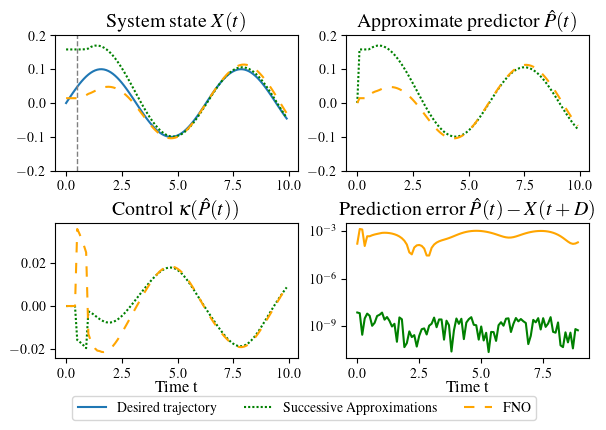

In [221]:
# Best trajectory
plot_trajectory(0, sim_config.t, int(round(0.5/0.1)), qdes, fno_best_states, numerical_best_states, \
                fno_best_predictors, numerical_best_predictors, fno_best_controls, numerical_best_controls, fno_config.model_type, saveFig="myFig.pdf")

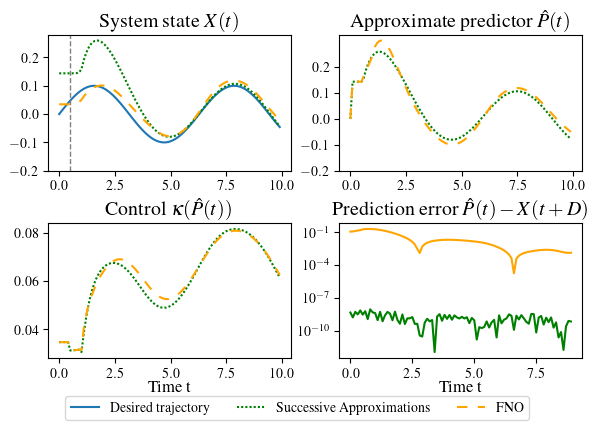

In [73]:
# Worst trajectorysum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, fno_best_states, numerical_worst_states, fno_worst_predictors, numerical_worst_predictors, fno_worst_controls, numerical_worst_controls, fno_config.model_type)

#### DeepONet Qualatative plots

In [76]:
# Simulate deeponet best case example
deeponet_best_states, deeponet_best_controls, deeponet_best_predictors = simulate_system(robot, best_ic_deeponet, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_deeponet, deeponet,verbose=True)
numerical_best_states, numerical_best_controls, numerical_best_predictors = simulate_system(robot, best_ic_deeponet, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, deeponet,verbose=True)

In [77]:
# Simulate deeponet worst case example
deeponet_worst_states, deeponet_worst_controls, deeponet_worst_predictors = simulate_system(robot, worst_ic_deeponet, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_deeponet, deeponet,verbose=True)
numerical_worst_states, numerical_worst_controls, numerical_worst_predictors = simulate_system(robot, worst_ic_deeponet, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, deeponet,verbose=True)

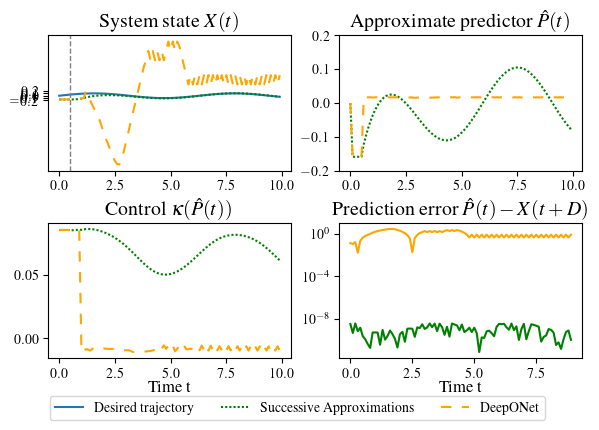

In [78]:
# Best trajectory
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, deeponet_best_states, numerical_best_states, deeponet_best_predictors, numerical_best_predictors, deeponet_best_controls, numerical_best_controls, deeponet_config.model_type)

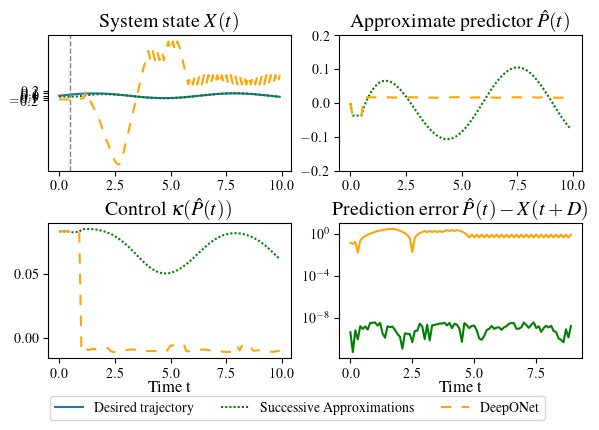

In [79]:
# Worst trajectory
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, deeponet_best_states, numerical_worst_states, deeponet_worst_predictors, numerical_worst_predictors, deeponet_worst_controls, numerical_worst_controls, deeponet_config.model_type)

#### FNO GRU Qualatative plots

In [82]:
# Simulate FNO GRU best case example
fno_gru_best_states, fno_gru_best_controls, fno_gru_best_predictors = simulate_system(robot, best_ic_fno_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_fno, fno_gru,verbose=True)
numerical_best_states, numerical_best_controls, numerical_best_predictors = simulate_system(robot, best_ic_fno_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, fno_gru,verbose=True)

In [83]:
# Simulate FNO GRU worst case example
fno_gru_worst_states, fno_gru_worst_controls, fno_gru_worst_predictors = simulate_system(robot, worst_ic_fno_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_fno, fno_gru,verbose=True)
numerical_worst_states, numerical_worst_controls, numerical_worst_predictors = simulate_system(robot, worst_ic_fno_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, fno_gru,verbose=True)

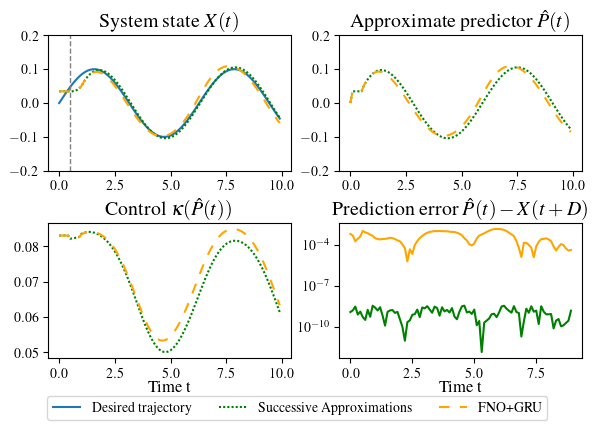

In [84]:
# Best trajectory
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, fno_gru_best_states, numerical_best_states, fno_gru_best_predictors, numerical_best_predictors, fno_gru_best_controls, numerical_best_controls, fno_gru_config.model_type)

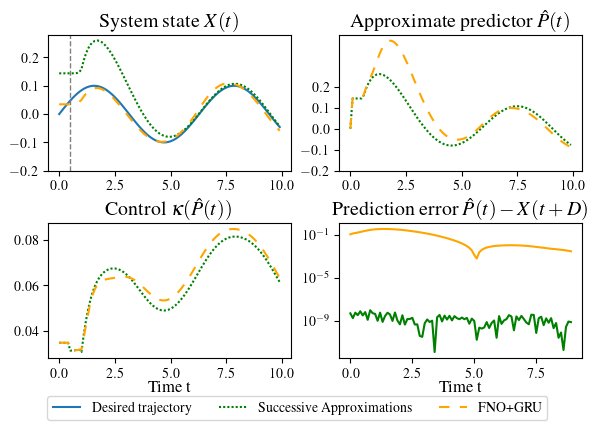

In [85]:
# Worst trajectory
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, fno_gru_best_states, numerical_worst_states, fno_gru_worst_predictors, numerical_worst_predictors, fno_gru_worst_controls, numerical_worst_controls, fno_gru_config.model_type)

#### DeepONet GRU Qualatative plots

In [86]:
# Simulate deeponet GRU best case example
deeponet_gru_best_states, deeponet_gru_best_controls, deeponet_gru_best_predictors = simulate_system(robot, best_ic_deeponet_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_deeponet, deeponet_gru,verbose=True)
numerical_best_states, numerical_best_controls, numerical_best_predictors = simulate_system(robot, best_ic_deeponet_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, deeponet_gru,verbose=True)

In [87]:
# Simulate deeponet G212.6626968383789 2.203989028930664 0.681304931640625 2.4077415466308594 1.038980484008789RU worst case example
deeponet_gru_worst_states, deeponet_gru_worst_controls, deeponet_gru_worst_predictors = simulate_system(robot, worst_ic_deeponet_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         ml_predictor_deeponet, deeponet_gru,verbose=True)
numerical_worst_states, numerical_worst_controls, numerical_worst_predictors = simulate_system(robot, worst_ic_deeponet_gru, qdes, qd_des, qdd_des, \
                                                                         sim_config.dt, sim_config.T,\
                                                                         sim_config.D, sim_config.dof,\
                                                                         robot.compute_predictors, deeponet_gru,verbose=True)

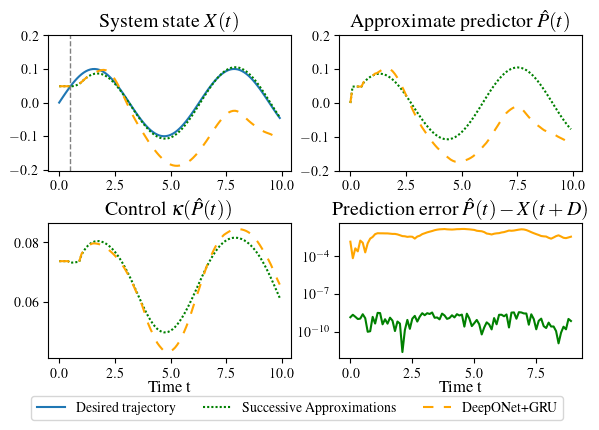

In [88]:
# Best trajectory
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, deeponet_gru_best_states, numerical_best_states, deeponet_gru_best_predictors, numerical_best_predictors, deeponet_gru_best_controls, numerical_best_controls, deeponet_gru_config.model_type)

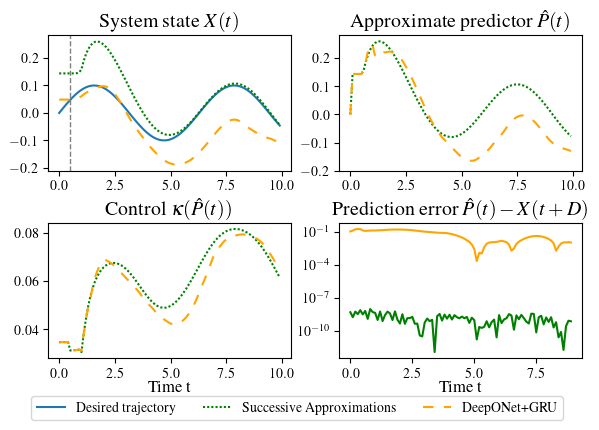

In [89]:
# Worst trajectory
plot_trajectory(4, sim_config.t, int(round(0.5/0.1)), qdes, deeponet_gru_best_states, numerical_worst_states, deeponet_gru_worst_predictors, numerical_worst_predictors, deeponet_gru_worst_controls, numerical_worst_controls, deeponet_gru_config.model_type)

### Comparion of computation time for various discretizations 

In [189]:
names = ["numerical", "deeponet", "fno", "fnogru", "deeponetgru"]
time_steps = [0.1, 0.05, 0.01]
delays = [0.1, 0.5,1]
predictor_trials = 10

numerical_times = np.zeros((len(time_steps), len(delays)))
deeponet_times = np.zeros((len(time_steps), len(delays)))
fno_times = np.zeros((len(time_steps), len(delays)))
fnogru_times = np.zeros((len(time_steps), len(delays)))
deeponetgru_times = np.zeros((len(time_steps), len(delays)))

In [213]:
for i, dt in enumerate(time_steps):
    for j, D in enumerate(delays):

        dof = sim_config.dof
        nD = int(round(D/dt))
        state = np.zeros(2*dof)
        controls = np.zeros((nD, dof))

        fno_config.update_config(input_channel=3*sim_config.dof, output_channel=2*sim_config.dof)
        fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel, sim_config.dof, nD)       
         
        deeponet_grid = np.arange(0, D, dt/(3*sim_config.dof)).astype(np.float32)
        deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
        deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=nD*2*sim_config.dof)
        deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                        deeponet_config.input_channel, deeponet_config.output_channel, \
                        deeponet_grid, sim_config.dof, nD)

        fno_gru_config.update_config(input_channel=3*sim_config.dof, output_channel=2*sim_config.dof)
        fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
        fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
                         fno_gru_config.output_channel, sim_config.dof, nD)
        
        deeponet_gru_grid = np.arange(0, D, dt/(3*sim_config.dof)).astype(np.float32)
        deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
        deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=nD*2*sim_config.dof)
        deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                         deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                         deeponet_gru_config.output_channel, deeponet_gru_grid, sim_config.dof, nD)

        
        alpha_mat = np.identity(dof)
        beta_mat = np.identity(dof)
        robot = Manipulator(dof, alpha_mat, beta_mat)

        # Numerical Predictor
        start_time = time.time()
        for k in range(predictor_trials):
            robot.compute_predictors(dt, state, controls, None)
        end_time = time.time()
        numerical_times[i][j] = (end_time-start_time)/predictor_trials*1000

        # FNO Predictor
        start_time = time.time()
        for k in range(predictor_trials):
            ml_predictor_fno(dt, state, controls, fno)
        end_time = time.time()
        fno_times[i][j] = (end_time-start_time)/predictor_trials * 1000

        # DeepONet Predictor
        start_time = time.time()
        for k in range(predictor_trials):
            ml_predictor_deeponet(dt, state, controls, deeponet)
        end_time = time.time()
        deeponet_times[i][j] = (end_time-start_time)/predictor_trials * 1000

        # FNO GRU Predictor
        start_time = time.time()
        for k in range(predictor_trials):
            ml_predictor_fno(dt, state, controls, fno_gru)
        end_time = time.time()
        fnogru_times[i][j] = (end_time-start_time)/predictor_trials * 1000

        # Deeponet GRU Predictor
        start_time = time.time()
        for k in range(predictor_trials):
            ml_predictor_deeponet(dt, state, controls, deeponet_gru)
        end_time = time.time()
        deeponetgru_times[i][j] = (end_time-start_time)/predictor_trials * 1000

In [214]:
model_names = ["Numerical", "FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU"]
model_times = [numerical_times, fno_times, deeponet_times, fnogru_times, deeponetgru_times]

# Delay header
header_delay = f"{'Delay(s)':<15}"
for delay in [0.5, 1, 2.0]:
    header_delay += f"{str(delay):<18}"  # 3 × 6-width cells per delay group
    header_delay += "  "  # 2-space gap between delay groups
print(header_delay)

# Step size header
header_dt = f"{'Step size':<15}"
for _ in range(3):  # One for each delay
    for dt in [0.1, 0.05, 0.01]:
        header_dt += f"{dt:<6.2f}"
    header_dt += "  "  # Same spacing between groups
print("-" * len(header_dt))
print(header_dt)
print("-" * len(header_dt))

# Data rows
for model, times in zip(model_names, model_times):
    row = f"{model:<15}"
    for delay_idx in range(3):
        for dt_idx in range(3):
            row += f"{times[dt_idx][delay_idx]:<6.2f}"
        row += "  "  # Group spacing
    print(row)

Delay(s)       0.5                 1                   2.0                 
---------------------------------------------------------------------------
Step size      0.10  0.05  0.01    0.10  0.05  0.01    0.10  0.05  0.01    
---------------------------------------------------------------------------
Numerical      2.31  4.56  20.48   11.27 20.54 101.93  22.56 40.94 204.21  
FNO            1.85  1.90  1.73    1.91  1.81  1.79    1.95  1.79  1.85    
DeepONet       0.44  0.44  0.41    0.44  0.44  0.42    0.46  0.42  0.50    
FNO+GRU        1.97  2.04  1.89    2.07  1.91  1.95    2.11  1.93  2.06    
DeepONet+GRU   0.62  0.60  0.59    0.65  0.59  0.76    0.67  0.60  1.14    
